## **Physics Informed Neural network for Burgers' Equation**
Satyajit Mojumder

# **PINN**:
*   Physics-informed neural networks (PINN) are type of a neural network where the physical law incorporates through the loss function of the neural netowrk.
*   PINN use governing equations to inform the training process
*   More accurate and reliable results where data is limited


# **Problem Definition**

 1D Burgers' equation:
 $\partial u/\partial t+u \partial u/ \partial x= \nu \partial^2u/\partial x^2, x\in [-1,1], t\in [0,1]$\
 Initial conditions:
 $u(x,0)=-sin(\pi x)$\
 Dirichlet boundary conditions:
 $u(-1,t)=u(1,t)=0$\
where


*   $u$ is a solution as a function of space and time, $u(x,t)$
*   $\nu$ is the viscosity cofficient, which controls the smoothness of the solution, for this tutorial consider $\nu=0.01/\pi$

# **Reference Result**
Download solution from here: https://github.com/lululxvi/deepxde/blob/master/examples/dataset/Burgers.npz



##Some features of Burgers' equation


*   Named after Dutch physicist Johannes Matinus Burgers

*   Captures interplay between nonlinearity and diffusion

*   Bridge between Linear and Nonlinear system

*   Reduced form of Navier Stokes equation

*   Shock formation and discontinituies

*   Application to Turbelence modeling to Traffic flow

*   Benchmark problem for numerical analysis and machine learning



##Mathematical formulation of the total loss function
The total loss function $\mathcal L_{total}$ has three components


1.   Inital condition loss, $\mathcal L_{IC}$
2.   Boundary condition loss, $\mathcal L_{BC}$
3.   PDE residuall loss, $\mathcal L_{PDE}$

#1. Initial condition loss, $\mathcal L_{IC}$
The initial condition for the burgers equation $u(x,0)=sin(\pi x)$ for all $x \in [-1, 1]$
The initial condition loss measure the discrepancy between the neural networks prediction $u_{NN}(x,0)$ and the true initial condition $u_{IC}(x)$.
Mathematically the initial condition loss $\mathcal L_{IC}$ is defined as the mean square error:

$\mathcal L_{IC}=\frac{1}{N_x}\sum_{i=1}^{N_x} (u_{NN}(x_i, 0)-u_{IC}(x_i))^2$,

where,


*   $N_x$ is the number of spatial points used to evaluate the initial conditions
*   $u_{NN}(x_i, 0)$ is the predicted value of $u_{NN}$ at $x=x_i, t=0$

*   $u_{IC}(x_i)=-sin(\pi x_i)$is the initial condition at $x=x_i$
This term ensures tha the network satifies the given initial conditions at $t=0$


# 2. Boundary Condition Loss, $ \mathcal{L}_{BC} $
The boundary condition for the Burgers' equation is specified as $ u(-1, t) = u(1, t) = 0 $ for all $ t \in [0, 1] $. This condition enforces that the solution $ u(x, t) $ is zero at the boundaries $ x = -1 $ and $ x = 1 $ over the time interval.

The **boundary condition loss** $ \mathcal{L}_{BC} $ measures the discrepancy between the neural network's predictions at the boundaries and the true boundary values. Mathematically, the boundary condition loss is defined as the mean square error:

$
\mathcal{L}_{BC} = \frac{1}{N_t} \sum_{j=1}^{N_t} [(u_{NN}(-1, t_j)-u_{BC}(-1, t_j))^2  +(u_{NN}(1, t_j)-u_{BC}(1, t_j))^2 ]
$

where:

* $ N_t $ is the number of time points used to evaluate the boundary conditions.
* $ u_{NN}(-1, t_j) $ and $ u_{NN}(1, t_j) $ are the neural network’s predicted values of $ u $ at $ x = -1 $ and $ x = 1 $, respectively, for time $ t = t_j $.
* $ u_{BC}(-1, t_j) $ and $ u_{BC}(1, t_j) $ are the true values of $ u $ at $ x = -1 $ and $ x = 1 $, respectively, for time $ t = t_j $
This term ensures that the network satisfies the given Dirichlet boundary conditions at $ x = -1 $ and $ x = 1 $ for all times $ t \in [0, 1] $.



# 3. PDE Loss, $ \mathcal{L}_{PDE} $
The **PDE loss** term enforces that the neural network's predictions approximately satisfy the 1D Burgers' equation:

$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}, \quad x \in [-1, 1], \; t \in [0, 1]
$

The **PDE loss** $ \mathcal{L}_{PDE} $ is computed by evaluating the mean square error between the left-hand side and right-hand side of the Burgers' equation at sampled points $(x_i, t_j)$ across space and time. It is given by:

$
\mathcal{L}_{PDE} = \frac{1}{N_x N_t} \sum_{i=1}^{N_x} \sum_{j=1}^{N_t} \left( \frac{\partial u_{NN}}{\partial t}(x_i, t_j) + u_{NN}(x_i, t_j) \frac{\partial u_{NN}}{\partial x}(x_i, t_j) - \nu \frac{\partial^2 u_{NN}}{\partial x^2}(x_i, t_j) \right)^2
$

where:

* $ N_x $ and $ N_t $ are the number of spatial and temporal points, respectively, where the PDE is evaluated.
* $ u_{NN} $ is the neural network’s predicted solution.
* $ \frac{\partial u_{NN}}{\partial t} $, $ \frac{\partial u_{NN}}{\partial x} $, and $ \frac{\partial^2 u_{NN}}{\partial x^2} $ are the neural network’s predicted partial derivatives, obtained via automatic differentiation.

This term ensures that the network approximately satisfies the PDE over the spatial and temporal domains.

# 4. Total Loss, $ \mathcal{L}_{total} $
The total loss function is the summation of the initial condition loss, boundary condition loss, and the PDE loss

$ \mathcal{L}_{total} = \mathcal{L}_{IC} +\mathcal{L}_{BC}+\mathcal{L}_{PDE} $



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
project_path = '/content/drive/MyDrive/Colab_Notebooks/PINNs/Burgers_Equation/'
os.chdir(project_path)
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


#Import Libraries#

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

#some plot settings
plt.close('all')
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size']=12
plt.rcParams['figure.dpi']=300

#Loading the reference solution of Burgers' Equation#

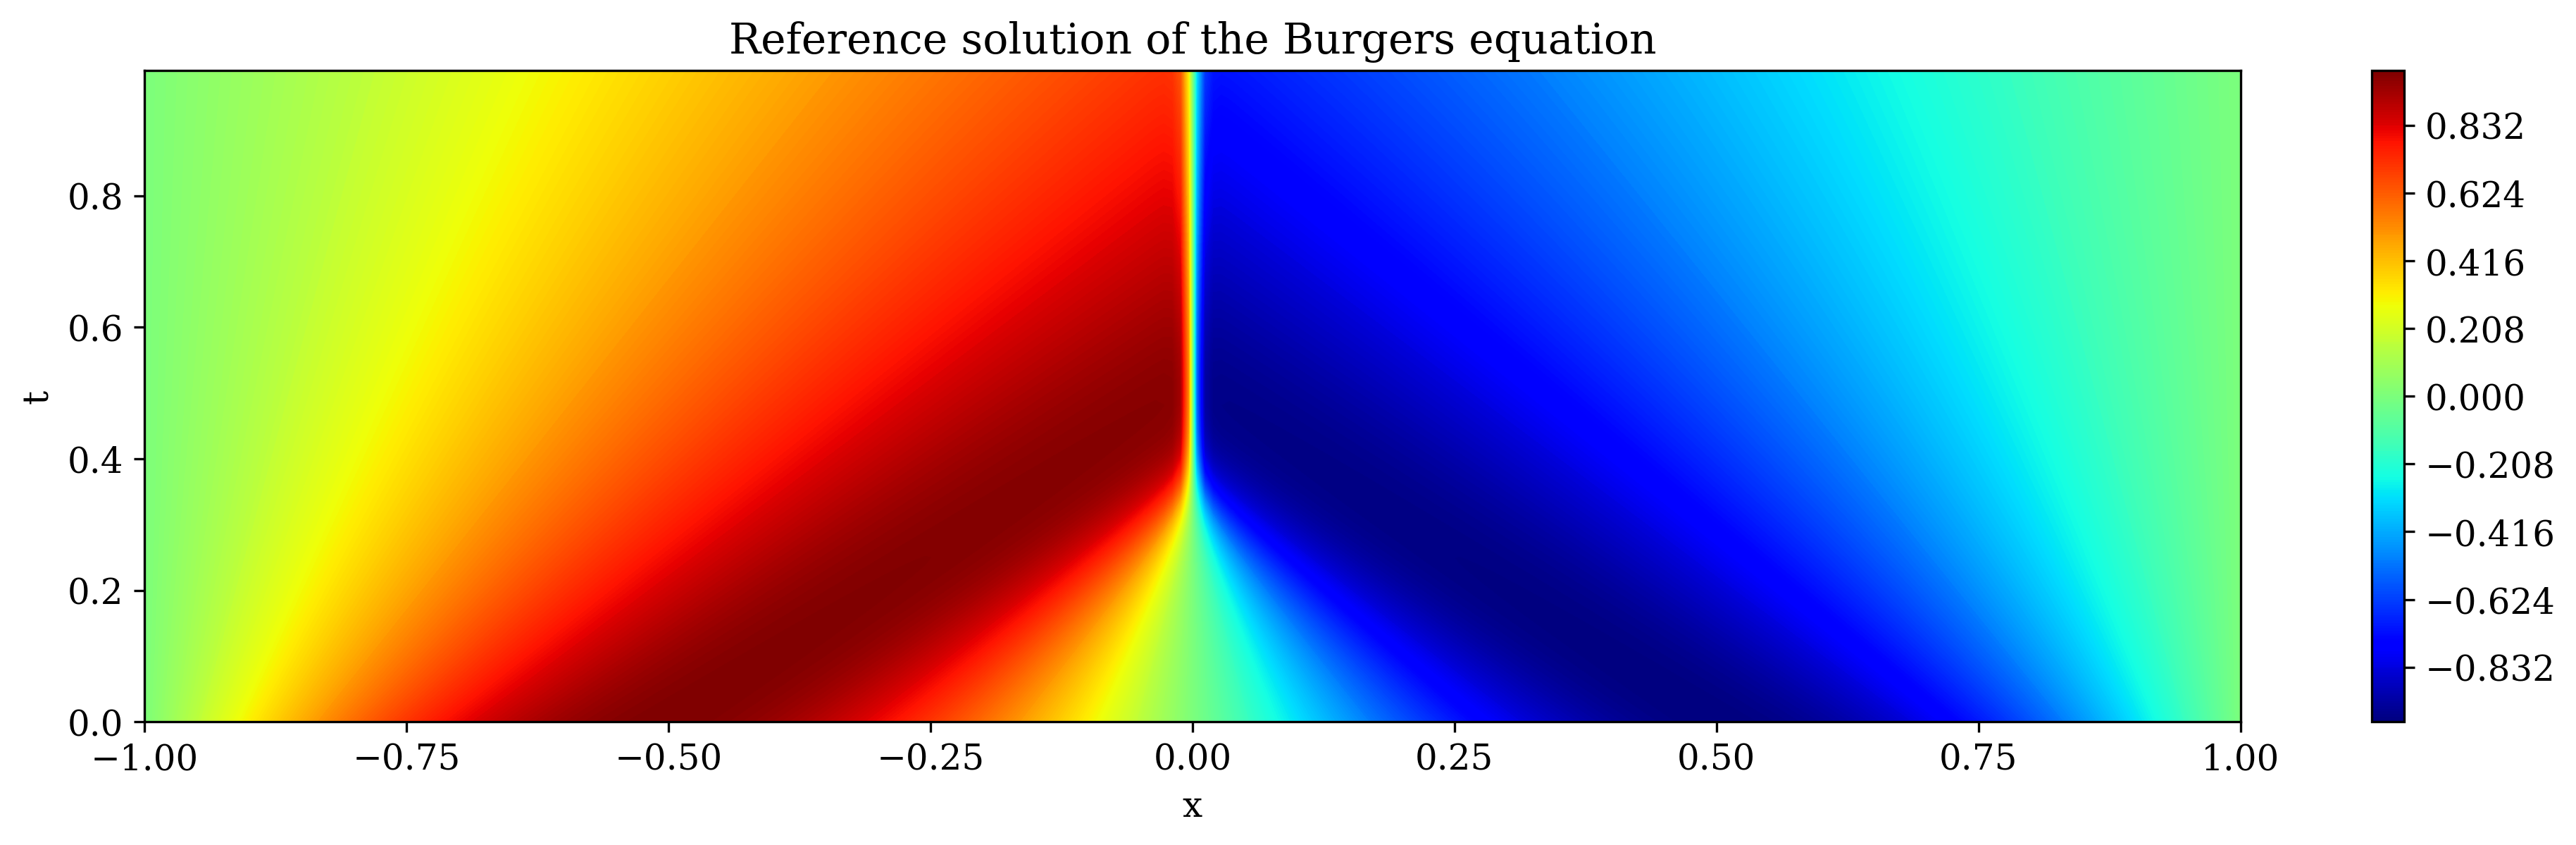

In [ ]:
#Load the reference solution
data=np.load("Burgers.npz")
t_ref=data["t"]
x_ref=data["x"]
u_ref=data["usol"].T

x_ref, t_ref = np.meshgrid(x_ref, t_ref)
plt.figure(figsize=(16,4))
plt.contourf(x_ref, t_ref, u_ref, levels=250, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Reference solution of the Burgers equation')
plt.show()

**Collocation points** are specific points in the spatial and temporal domain where a partial differential equation (PDE) or an equation constraint is enforced in numerical methods. In the context of solving PDEs using machine learning models or traditional numerical methods, collocation points are crucial for approximating the solution by ensuring it satisfies the governing equation and boundary/initial conditions at these discrete points.

#Defining the collocation, boundary and initial points#

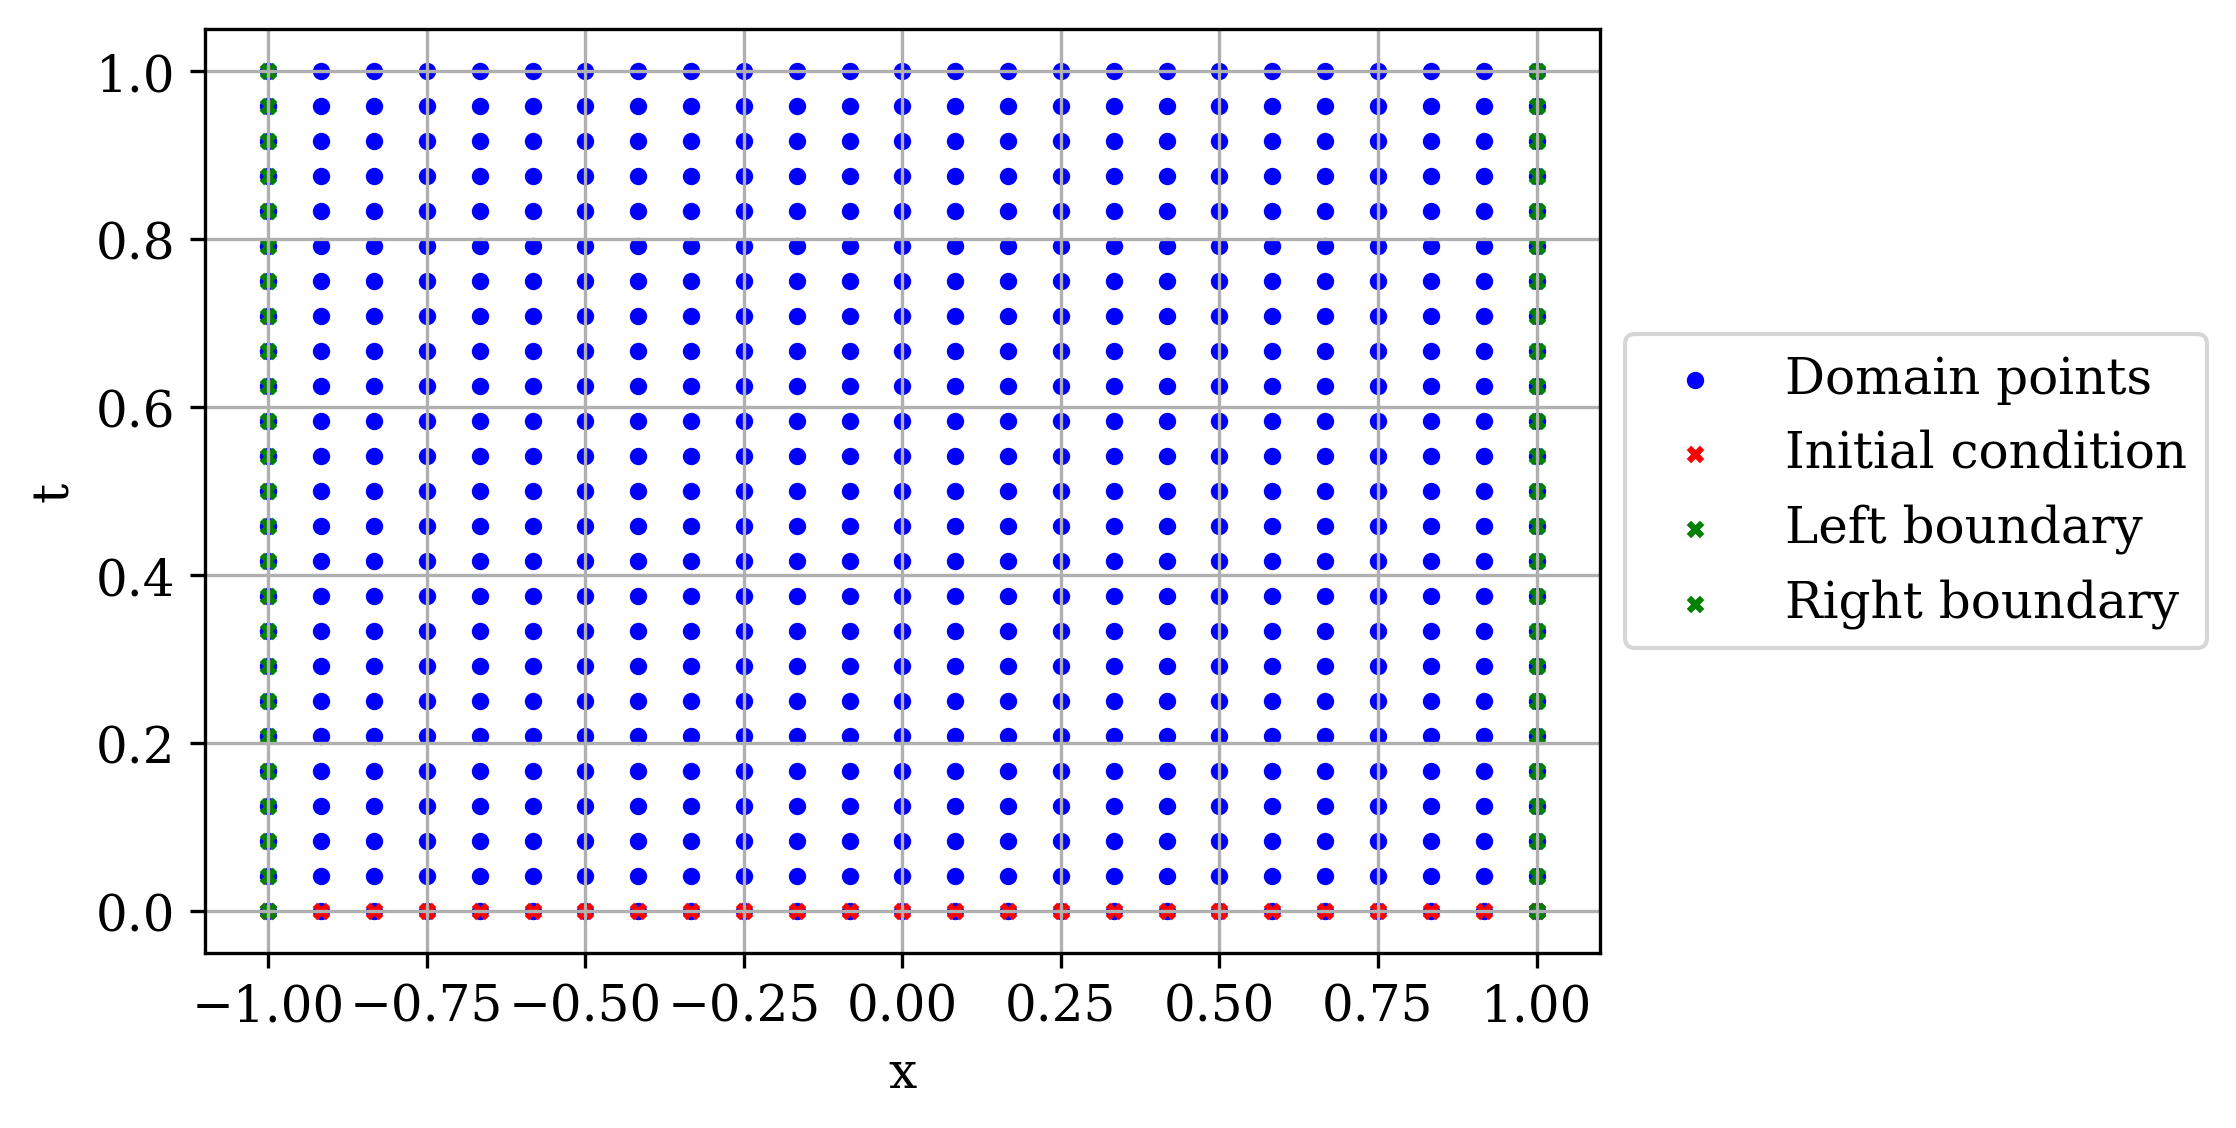

In [ ]:
#Define collocation points
x_values=torch.linspace(-1,1,25).view(-1,1) #Spatial points; shape: (25, 1)
t_values=torch.linspace(0,1,25).view(-1,1) #Temporal points; shape: (25, 1)

x_collocation,t_collocation=torch.meshgrid(x_values.squeeze(),t_values.squeeze(), indexing='xy') #625 grid points covering the whole space-time domain

#Flatten the grids into 1D lists of points
x_collocation = x_collocation.reshape(-1, 1)  # shape: (625, 1)
t_collocation = t_collocation.reshape(-1, 1)  # shape: (625, 1)

#Extract boundary points
x_boundary_left=torch.full_like(t_values, -1.0) #left boundary at x=-1
x_boundary_right=torch.full_like(t_values, 1.0) #right boundary at x=1
t_boundary=t_values #time points for the boundary

#Extract initial condition points
t_initial_condition=torch.zeros_like(x_values) #time is zero
x_initial_condition=x_values #x varies

#Convert tensors to numpy arrays for plotting
x_collocation_np=x_collocation.numpy()
t_collocation_np=t_collocation.numpy()

x_initital_condition_np=x_initial_condition.numpy()
t_initial_condition_np=t_initial_condition.numpy()

x_boundary_left_np=x_boundary_left.numpy()
x_boundary_right_np=x_boundary_right.numpy()
t_boundary_np=t_boundary.numpy()

#Plot the geometry and the scatter points
plt.figure(figsize=(6,4))
plt.scatter(x_collocation_np, t_collocation_np, c='b', marker='o', label='Domain points',s=10)
plt.scatter(x_initital_condition_np, t_initial_condition_np, c='r', marker='x', label='Initial condition',s=10)
plt.scatter(x_boundary_left_np, t_boundary_np, c='g', marker='x', label='Left boundary',s=10)
plt.scatter(x_boundary_right_np, t_boundary_np, c='g', marker='x', label='Right boundary',s=10)
plt.xlabel('x')
plt.ylabel('t')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

## Implementation steps

1. **Set up the neural network architecture:** Define the input layer, hidden layer and output layers

2. **Define the loss function:** Incorporate the PDE residuals, initial and boundary conditions loss.

3. **Train the model:** Train the neural network by minimizing the loss function

4. **Evaluate the results:** Comapre the neural network predicted solution with the reference solution.

#Model Architecture#

In [ ]:
#Setting up the NN architecture

class PINN(nn.Module):
  def __init__(self):
    super(PINN, self).__init__()
    self.hidden=nn.Sequential(
        nn.Linear(2, 20),        # input layer: 2 features → 20 neurons
        nn.Tanh(),
        nn.Linear(20, 20),
        nn.Tanh(),
        nn.Linear(20, 20),
        nn.Tanh(),
        nn.Linear(20, 20),
        nn.Tanh(),
        nn.Linear(20,1)         # output layer: 1 neuron for scalar output u(x, t)
    )

  def forward(self, x,t):
      inputs=torch.cat((x,t),dim=1) #concatenate x and t along the second axis; shape: (N, 2)
      u=self.hidden(inputs)
      return u


#Loss Functions#

In [ ]:
#Define the PDE residual loss
def pde_residual(x,t,model, nu=0.01):
  x.requires_grad=True
  t.requires_grad=True

  u=model(x,t)
  u_t=torch.autograd.grad(u,t, torch.ones_like(u), create_graph=True)[0] #du/dt
  u_x=torch.autograd.grad(u,x, torch.ones_like(u), create_graph=True)[0] #du/dx
  u_xx=torch.autograd.grad(u_x,x, torch.ones_like(u_x), create_graph=True)[0] #d^2u/dx^2

  residual=u_t+u*u_x-nu/(np.pi)*u_xx #residual of the Burgers's equation
  return residual

#Define the initial and boundary conditions
def initial_conditions(x):
  return -torch.sin(np.pi*x)  #returns the exact solution for u(x,0)

def boundary_conditions(x,t):
  return torch.zeros_like(t)  #returns 0 at all boundary locations


In [ ]:
#Create training data
x=torch.linspace(-1,1,100).view(-1,1) #spatial points
t=torch.linspace(0,1,100).view(-1,1) #temporal points
x_train, t_train=torch.meshgrid(x.squeeze(),t.squeeze(), indexing='xy')
x_train=x_train.reshape(-1,1)
t_train=t_train.reshape(-1,1)

In [ ]:
#Define the model, optimizer, and loss function
model=PINN()
optimizer=optim.Adam(model.parameters(), lr=0.001)

#Training#

In [ ]:
#Training loop
num_epochs=1000

for epoch in range(num_epochs):

  model.train()

  #compute initial condition loss
  u_pred=model(x,torch.zeros_like(x)) #model is computing u(x,0)---predictions from model
  u_true=initial_conditions(x)        #true values/ground truth for Initial Condition

  loss_ic=torch.mean((u_pred-u_true)**2) #Mean Squared Error of Initial Condition


  #compute boundary loss
  u_pred_left=model(torch.full_like(t, -1.0),t) #model is computing u(-1,t)
  u_pred_right=model(torch.full_like(t, 1.0),t) #model is computing u(1,t)

  loss_bc=torch.mean((u_pred_left-boundary_conditions(torch.full_like(t, -1.0),t))**2) +\
          torch.mean((u_pred_right-boundary_conditions(torch.full_like(t, 1.0),t))**2) #Mean Squared Error of Left and Right Boundary Condition

  #compute pde residual loss
  residual=pde_residual(x_train,t_train,model)
  loss_pde=torch.mean(residual**2) #MSE of PDE residual

  #total loss
  loss=loss_ic+loss_bc+loss_pde

  #Backward and optimize
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if (epoch+1)%50==0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [50/1000], Loss: 0.4351
Epoch [100/1000], Loss: 0.4018
Epoch [150/1000], Loss: 0.2220
Epoch [200/1000], Loss: 0.1604
Epoch [250/1000], Loss: 0.1567
Epoch [300/1000], Loss: 0.1535
Epoch [350/1000], Loss: 0.1500
Epoch [400/1000], Loss: 0.1453
Epoch [450/1000], Loss: 0.1384
Epoch [500/1000], Loss: 0.1300
Epoch [550/1000], Loss: 0.1234
Epoch [600/1000], Loss: 0.1185
Epoch [650/1000], Loss: 0.1142
Epoch [700/1000], Loss: 0.1109
Epoch [750/1000], Loss: 0.1075
Epoch [800/1000], Loss: 0.1053
Epoch [850/1000], Loss: 0.1034
Epoch [900/1000], Loss: 0.1019
Epoch [950/1000], Loss: 0.1006
Epoch [1000/1000], Loss: 0.0994


#Prediction#

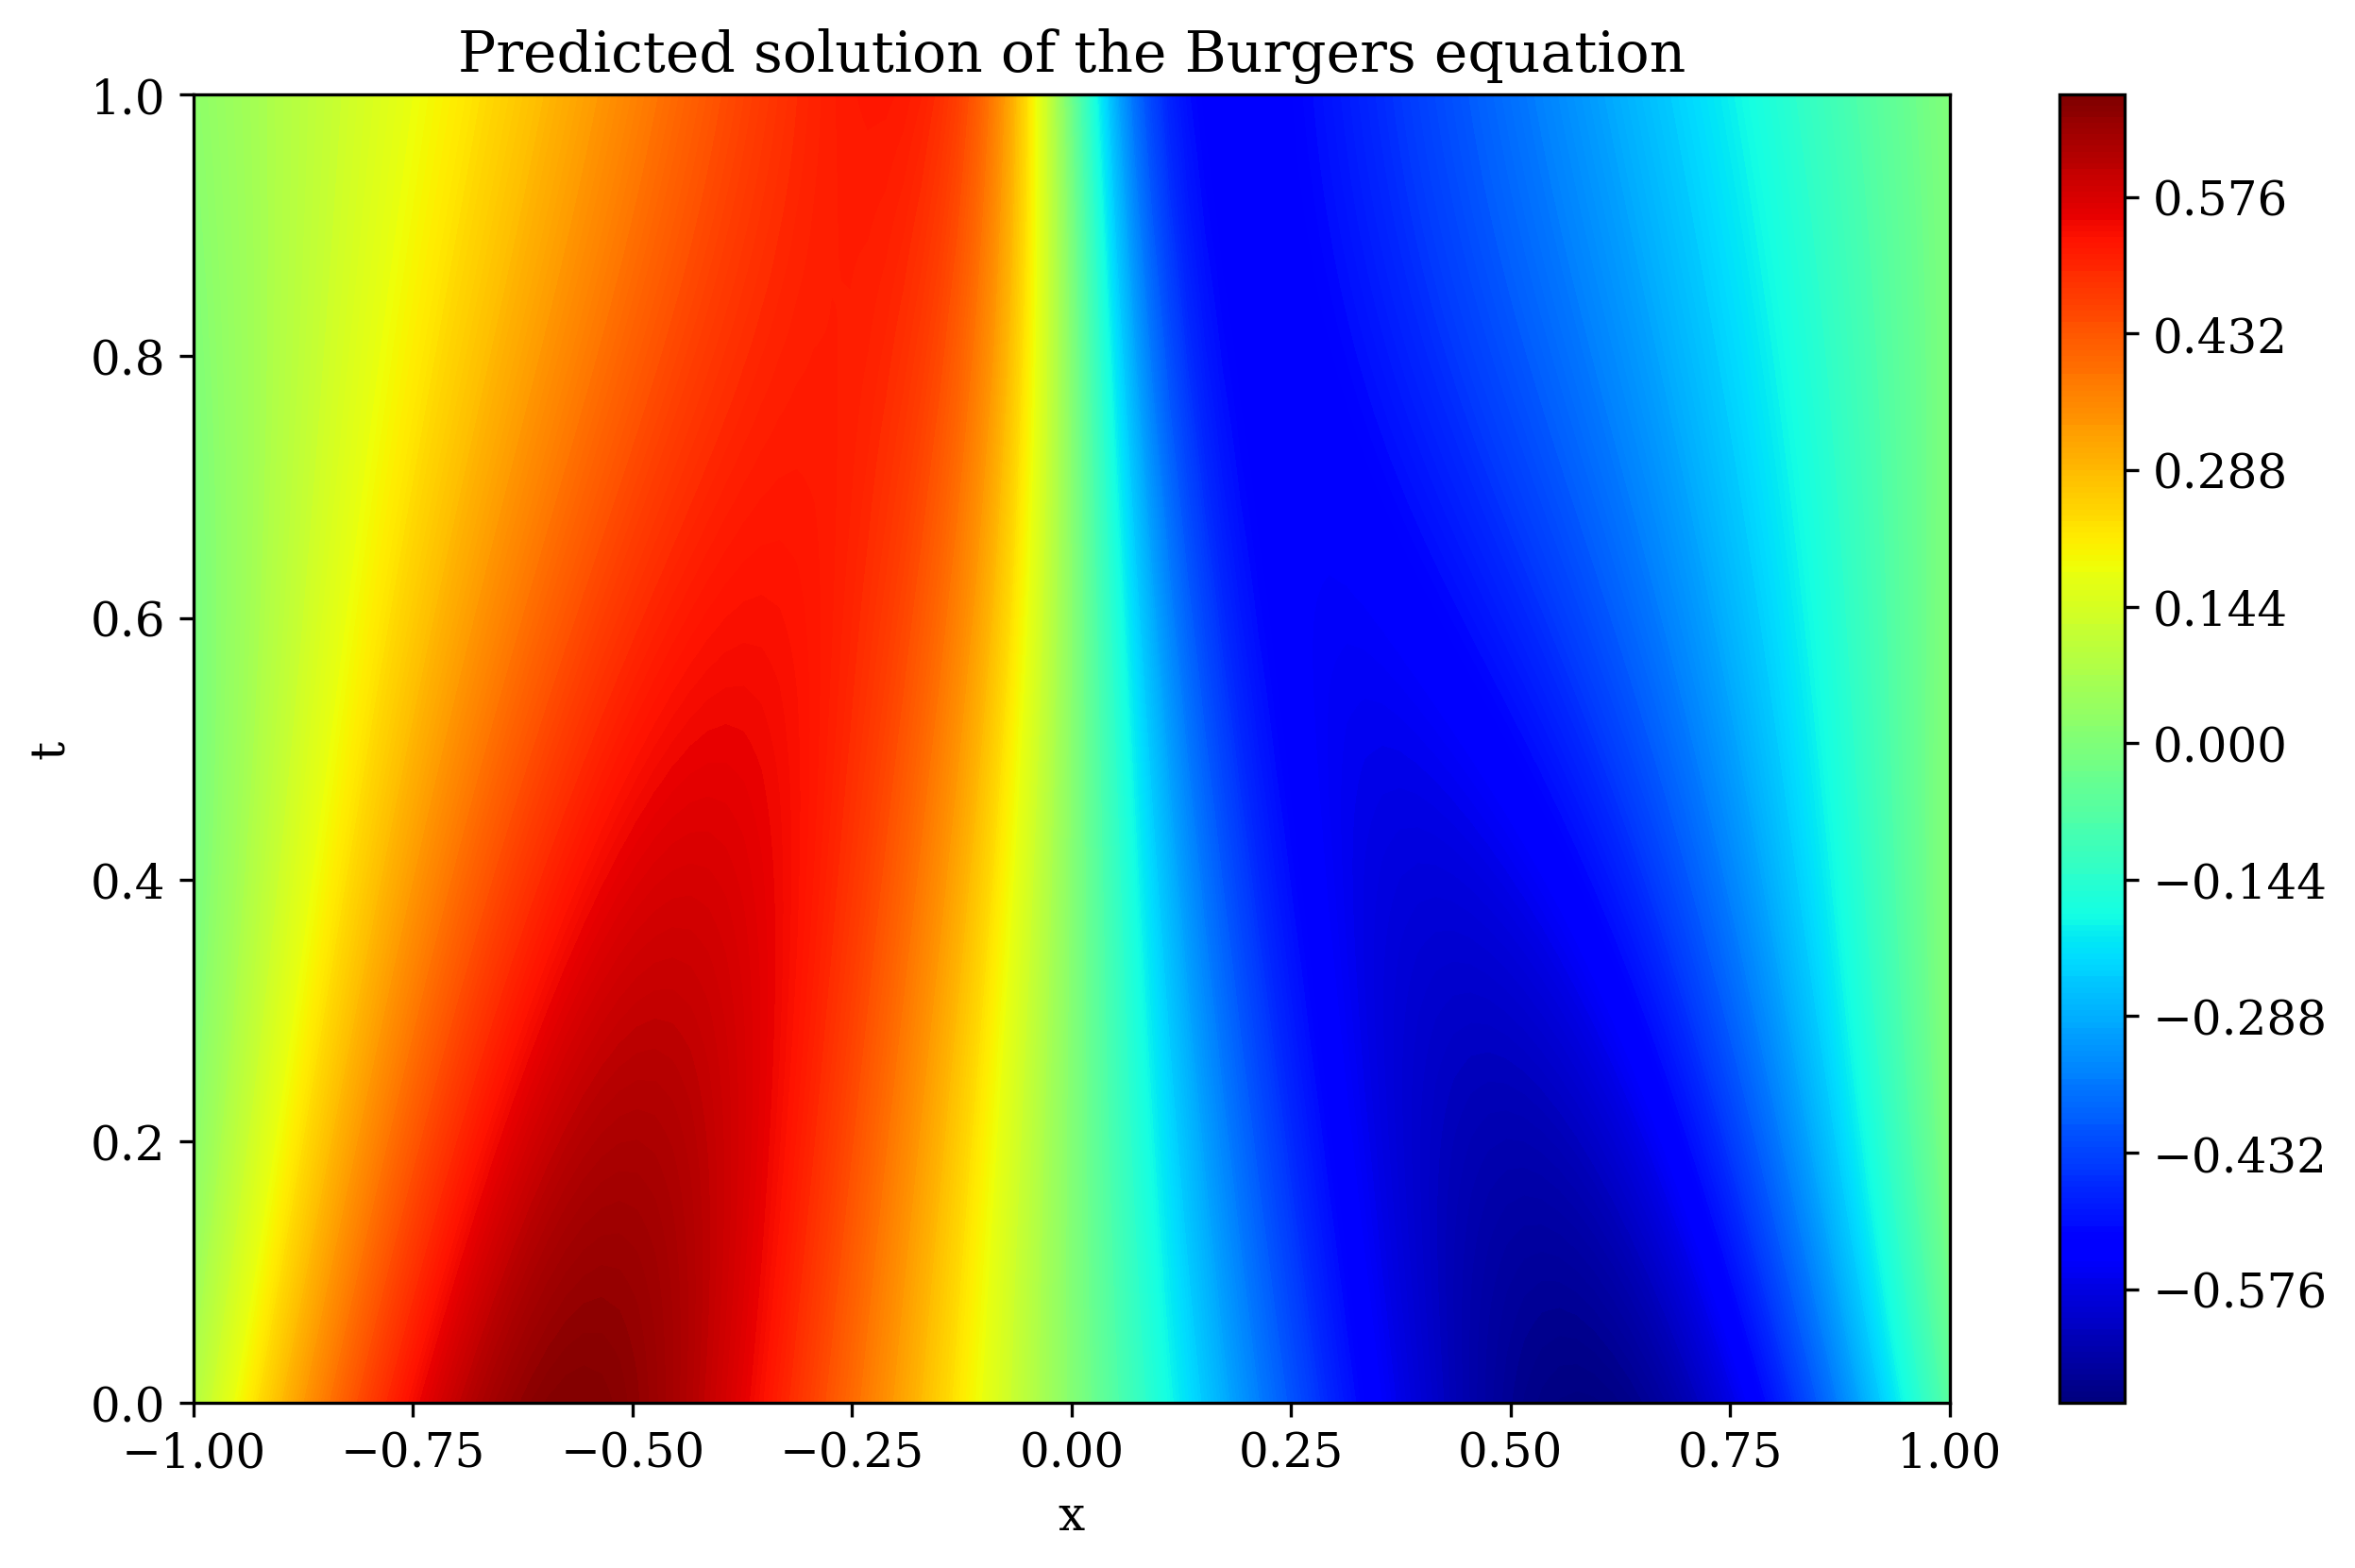

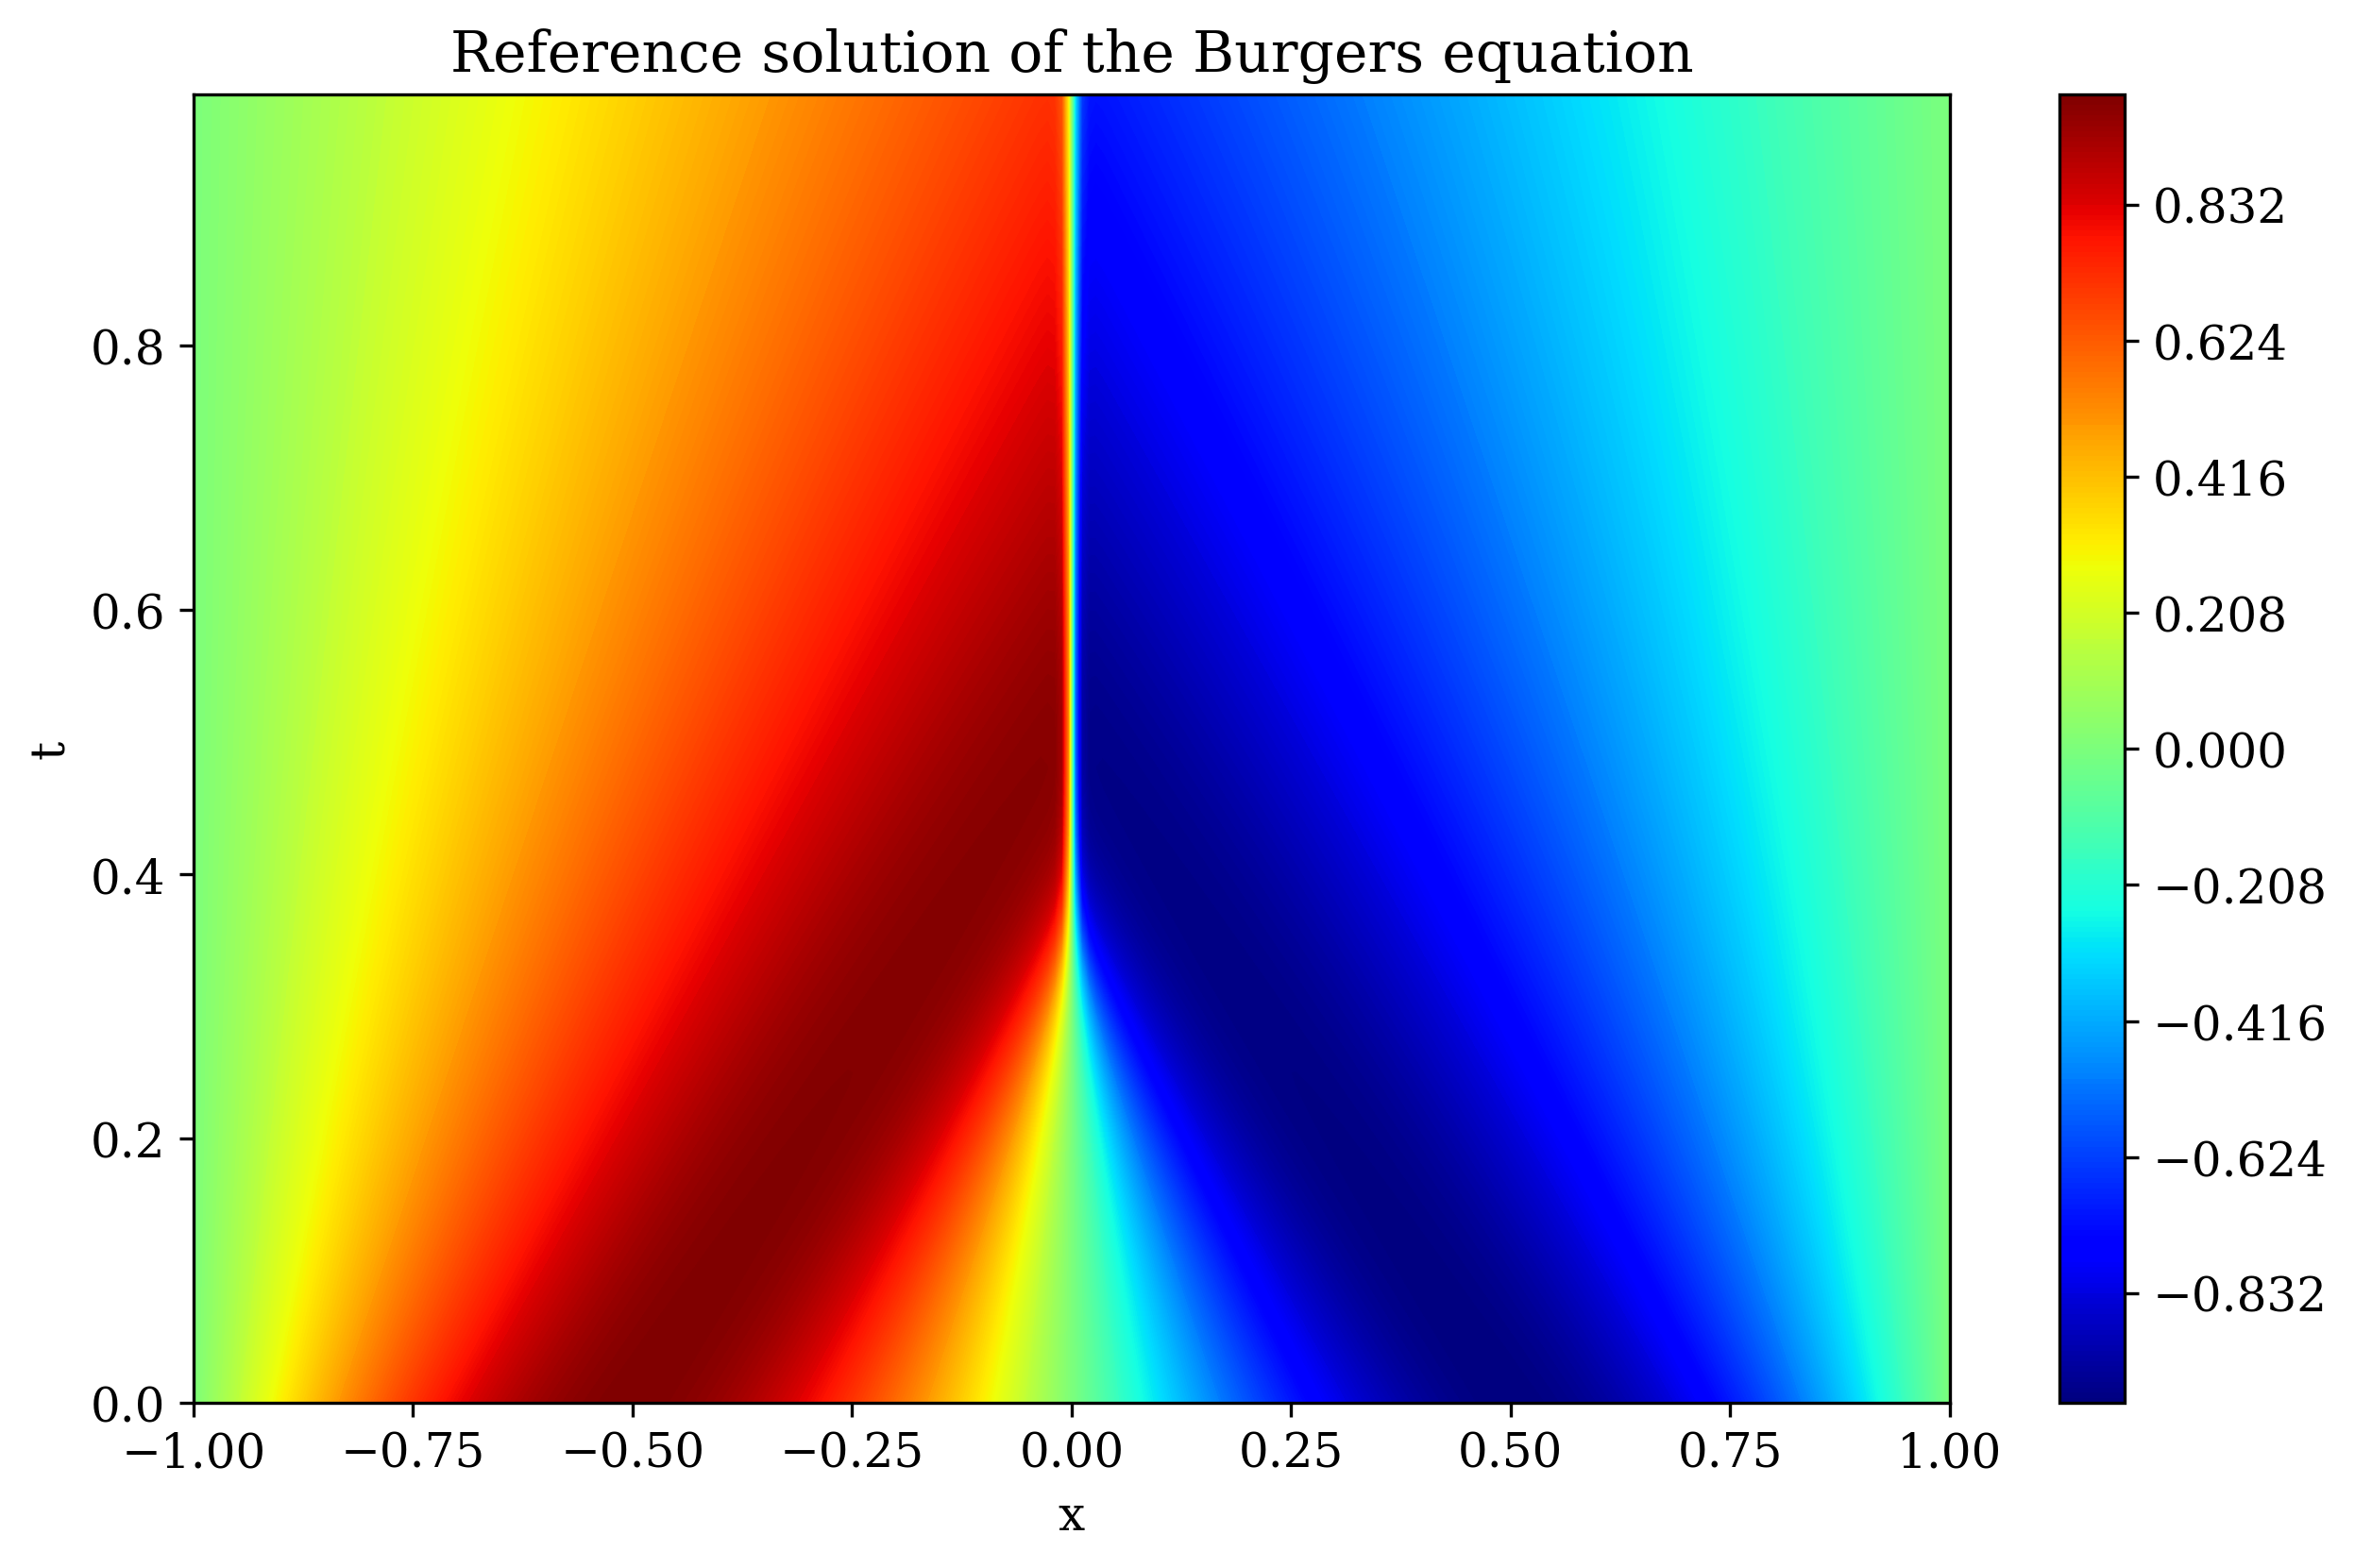

In [ ]:
#Evaluate the model in a grid of (x,t) values
x_test=torch.linspace(-1,1,100).view(-1,1)
t_test=torch.linspace(0,1,100).view(-1,1)
x_test, t_test=torch.meshgrid(x_test.squeeze(),t_test.squeeze(), indexing='xy')
x_test=x_test.reshape(-1,1)
t_test=t_test.reshape(-1,1)

model.eval()
with torch.no_grad():
  u_pred=model(x_test,t_test).numpy()

#Reshape the predicted u values for plotting
x_test=x_test.numpy().reshape(100,100)
t_test=t_test.numpy().reshape(100,100)
u_pred=u_pred.reshape(100,100)

#Plot the predicted solution
plt.figure(figsize=(10,6))
plt.contourf(x_test, t_test, u_pred, levels=250, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted solution of the Burgers equation')
plt.show()

#Load the reference solution
data=np.load("Burgers.npz")
t_ref=data["t"]
x_ref=data["x"]
u_ref=data["usol"].T

x_ref, t_ref = np.meshgrid(x_ref, t_ref)
plt.figure(figsize=(10,6))
plt.contourf(x_ref, t_ref, u_ref, levels=250, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Reference solution of the Burgers equation')
plt.show()


#Time Slices for better visualization#

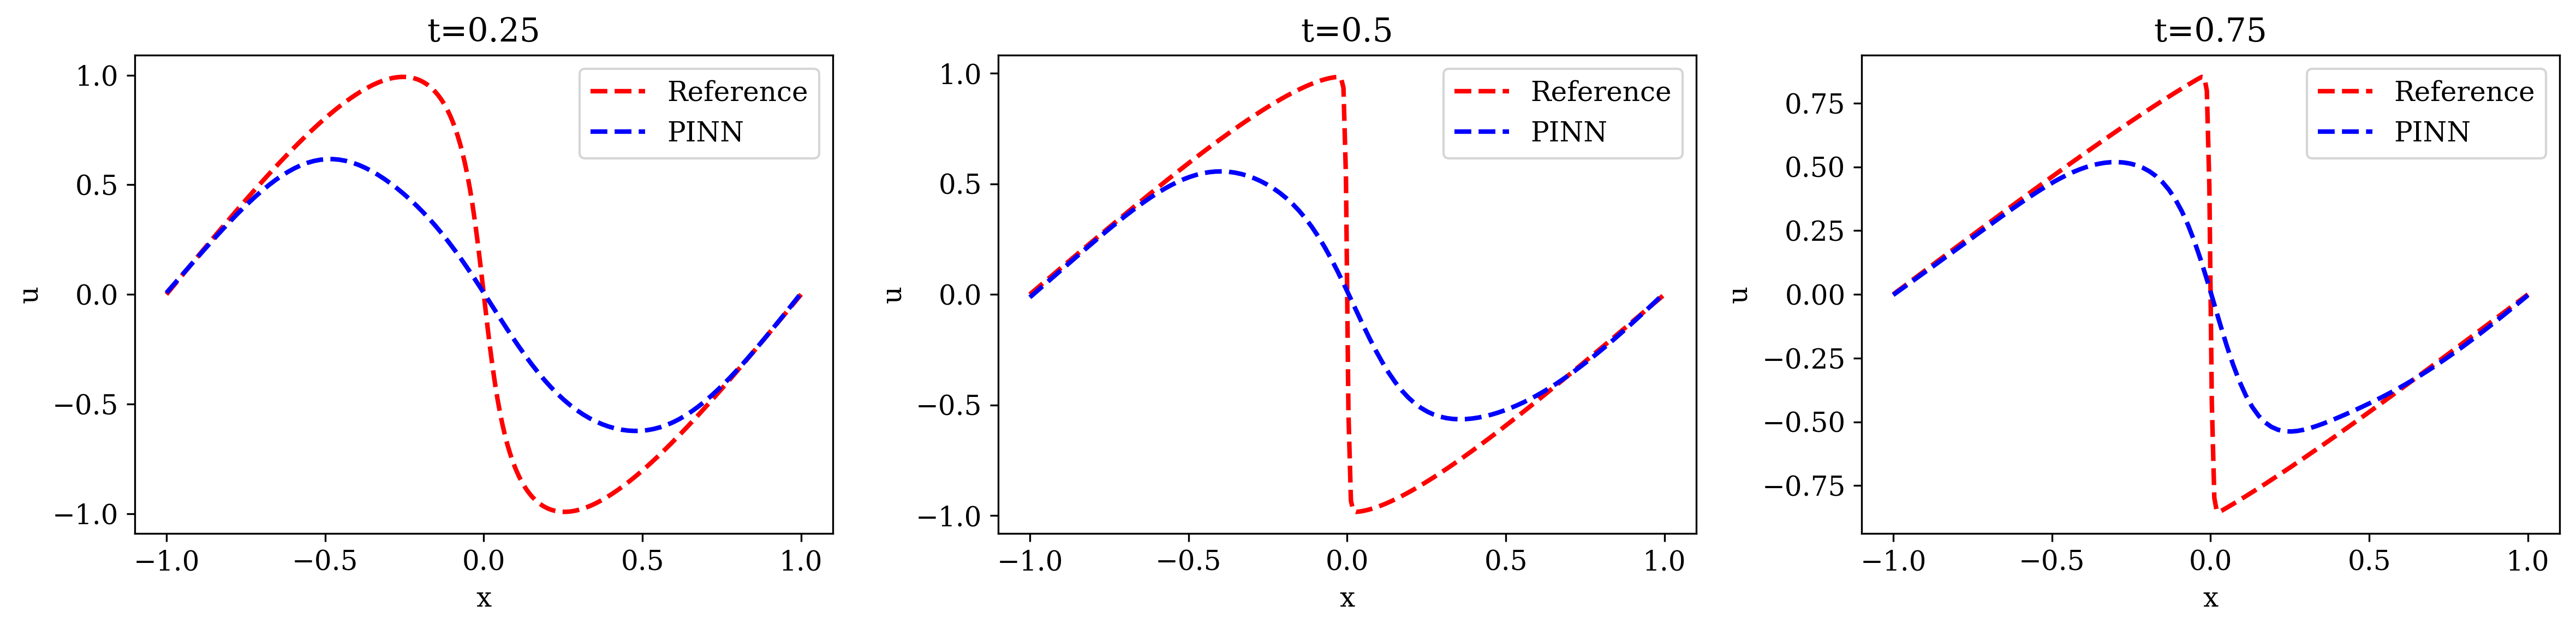

In [ ]:
#Showing a line plot for better visulization
time_slices=[0.25, 0.50, 0.75]
num_plots=len(time_slices)
cols=3 # no of columns in the plot
rows=num_plots//cols + (1 if num_plots%cols else 0) #no of rows in the plot
#create the subplot grid
fig,axs=plt.subplots(rows,cols,figsize=(16,4*rows))
axs=axs.flatten() #flatten the axes array for easy indexing
#plot the data for each item slice
for i, t_val in enumerate(time_slices):
  idx_ref=np.argmin(np.abs(t_ref[:,0]-t_val))
  u_ref_slice=u_ref[idx_ref,:]

  #Get PINN solution at the specefic time
  t_slice=t_val*np.ones((100,1))
  x_slice=np.linspace(-1,1,100).reshape(-1,1)

  model.eval()
  with torch.no_grad():
    u_pinn_slice=model(torch.tensor(x_slice, dtype=torch.float32),torch.tensor(t_slice, dtype=torch.float32)).numpy()

  #Plot the reference and the PINN solution
  axs[i].plot(x_ref[0,:],u_ref_slice,'r--',label='Reference',linewidth=2)
  axs[i].plot(x_slice,u_pinn_slice,'b--',label='PINN',linewidth=2)
  axs[i].set_xlabel('x')
  axs[i].set_ylabel('u')
  axs[i].set_title(f't={t_val}')
  axs[i].legend()

plt.tight_layout()
plt.show()